In [1]:
# !pip install opencv-python==3.4.0.14 
# !pip install -U numpy
# !pip install scikit-learn
# !pip install matplotlib

import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# import numpy
print(np.__version__)

1.24.1


In [3]:
EPOCHS = 50 #25
INIT_LR = 1e-3
BS = 64 #32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C:/Users/Ashutosh Shukla/Desktop/tomato'
width=256
height=256
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
#     print(root_dir) ################
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)
#             print(f'{directory} removed') ############

    for plant_folder in root_dir :
        if plant_folder == 'PlantVillage':
    #         print(plant_folder) ##############
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
#             print(plant_disease_folder_list) ################

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)
    #                 print(f'{disease_folder} removed') ############


            for plant_disease_folder in plant_disease_folder_list:
#                 print(plant_disease_folder) #############
                print(f"[INFO] Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
    #             print(plant_disease_image_list) #############

                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)

                for image in plant_disease_image_list[:800]:
                    image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                        image_list.append(convert_image_to_array(image_directory))
                        label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [14]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [15]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/50
136/136 [==============================] - 57s 359ms/step - loss: 0.3865 - accuracy: 0.4450 - val_loss: 0.5099 - val_accuracy: 0.1227
Epoch 2/50
136/136 [==============================] - 46s 339ms/step - loss: 0.1081 - accuracy: 0.7305 - val_loss: 1.5359 - val_accuracy: 0.1144
Epoch 3/50
136/136 [==============================] - 46s 336ms/step - loss: 0.1702 - accuracy: 0.6090 - val_loss: 0.1725 - val_accuracy: 0.5551
Epoch 4/50
136/136 [==============================] - 46s 337ms/step - loss: 0.0964 - accuracy: 0.7835 - val_loss: 0.1514 - val_accuracy: 0.6059
Epoch 5/50
136/136 [==============================] - 46s 339ms/step - loss: 0.0747 - accuracy: 0.8373 - val_loss: 0.1999 - val_accuracy: 0.5913
Epoch 6/50
136/136 [==============================] - 46s 337ms/step - loss: 0.0635 - accuracy: 0.8580 - val_loss: 0.4974 - val_accuracy: 0.5314
Epoch 7/50
136/136 [==============================] - 46s 337ms/step - loss: 0.0563 - accuracy: 0.8806 - val_loss: 0.4877 - val_ac

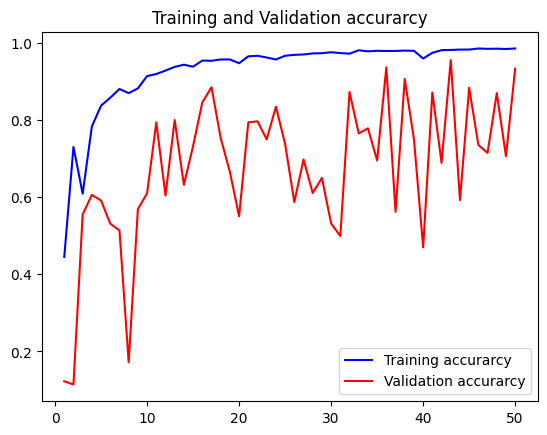

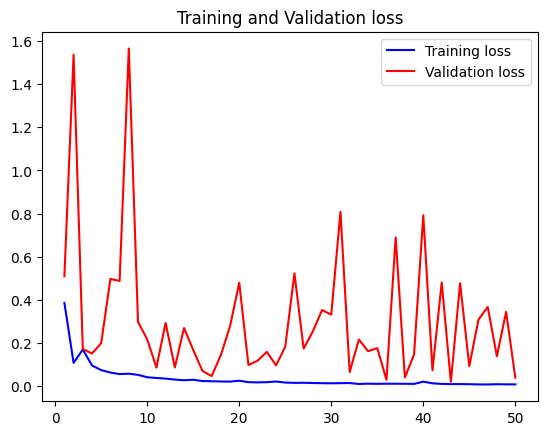

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
69/69 [==============================] - 1s 10ms/step - loss: 0.0400 - accuracy: 0.9332
Test Accuracy: 93.31807494163513


In [18]:
print("[INFO] Saving model...")
model.save('C:\\Users\\Ashutosh Shukla\\Desktop\\tomato\\model2.h5')

[INFO] Saving model...


In [19]:
from tensorflow.keras.models import load_model
loaded_model = load_model('C:\\Users\\Ashutosh Shukla\\Desktop\\tomato\\model2.h5')

In [20]:
image_dir="C:\\Users\\Ashutosh Shukla\\Desktop\\tomato\\PlantVillage\\Potato___Early_blight\\00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [21]:
result=loaded_model.predict(npp_image)

print(result)

1/1 [==============================] - 0s 216ms/step
[[3.2513007e-12 1.0886356e-09 9.9910706e-01 7.3759052e-06 2.3983993e-10
  3.5114922e-09 1.2144702e-07 8.8488293e-04 3.4738375e-07 5.0433940e-08
  3.8651377e-10 8.5447827e-10 3.4091410e-12 1.6290383e-09 5.7294187e-08]]


In [22]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99910706
Potato___Early_blight
